# Appliances Energy Forecasting

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
import pickle
from datetime import timedelta, datetime
from urllib.parse import quote
from statsmodels.tsa.seasonal import seasonal_decompose

## Import necessary API
import sys
sys.path.append('../../../../')
from api.v2.util.data_load import data_load
from api.v2.model.BILSTM import BiLSTM
from api.v2.util.set_minmax import set_minmax_value
from api.v2.Preprocessing.MinMaxScaler import MinMaxScaler
from api.v2.util.compare_graph import compare_graph

## Import libraries for the model
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results 
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Base Parameter Setting
* Set parameters based on the information identified during EDA (Exploratory Data Analysis).

In [2]:
# Set Appliance Energy Data Base Parameter

# Set MachBase Neo URL address
URL = 'http://127.0.0.1:5654'
# Set Tag Table Name
table = 'appliance_energy'
# Set TimeFormat - > 'default' or '2006-01-02 15:04:05.000000'(Divided down to the nanosecond)
timeformat = 'Default'
# Set resample Option -> D(day), H(hour), T(minute), S(second)
resample_freq = None
# Set the desired tag names
tags = ['Appliances']
# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)
# Set Tag Name
name = quote(tags_, safe=":/")
# Set Start time
start_time = '2016-01-11 17:00:00'
# Set End time 
end_time = '2016-05-27 18:00:00'
# Set TimeFormat - > 'default' or quote('2006-01-02 15:04:05.000000')(Divided down to the nanosecond)
timeformat = 'default'

## Model Configuration
* Using BILSTM model.

In [3]:
# Model configuration parameters

# number of input data columns
# last number in print(list(train_dataloader)[0][0].shape)
input_dim = 4

# Window size
window_size = 6

# BILSTM hidden state size
hidden_dim = 64

# layer size
num_layers = 2

# Learning rate
learning_rate = 0.01

# Model configuration
model = BiLSTM(input_dim, hidden_dim, num_layers, window_size, dropout=0.2).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

BiLSTM(
  (bilstm): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


## Dataset & Loader Setup

### Window Dataset Configuration
* To train on time series data, you need to set the window size and the sliding step.

* Window size: Determines how many time points to group together.
* Step size: The time interval by which the window moves.

In [4]:
# Sliding Window Dataset Configuration
class SlidingWindowDataset(Dataset):
    def __init__(self, data, window_size, step_size):
        self.data = data
        self.window_size = window_size
        self.step_size = step_size
        self.windows, self.targets = self._create_windows()
    
    # Set up sliding windows
    def _create_windows(self):
        windows = []
        targets = []
        for i in range(0, len(self.data) - self.window_size + 1, self.step_size):
            window = self.data.iloc[i:i + self.window_size, :-1].values  # Exclude the last column
            target_array = self.data.iloc[i:i + self.window_size, -1].values  # The last column is the target
                
            windows.append(torch.Tensor(window))
            targets.append(torch.Tensor(target_array))  # Convert target to Tensor
        return windows, targets
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return self.windows[idx], self.targets[idx]

## Set decomp & lags function

In [5]:
# Set Function
def decomp(df):
    # Time series decomposition
    decomposition = seasonal_decompose(df['Appliances'], model='additive', period=24)

    # Use only the trend
    trend = decomposition.trend 
    
    # Create a new DataFrame
    df = pd.DataFrame(trend.dropna().values, columns=['value'])
    df.index = trend.dropna().index
    
    # Create new columns with window applied
    df['lag4'] = df['value'].shift(4)  # Previous 40-min data
    df['lag3'] = df['value'].shift(3)  # Previous 30-min data
    df['lag2'] = df['value'].shift(2)  # Previous 20-min data 
    df['lag1'] = df['value'].shift(1)  # Previous 10-min data 
    
    # Remove missing values
    df = df.dropna()
    
    # Move 'value' column to the end
    df['value'] = df.pop('value')
    
    return df

## Model Training

In [6]:
# Model training function
def train(epochs, start_time_train, end_time_train, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler_data, scaler_target, Min, Max, batch_size, window_size, step_size):
    
    # Initialize training loss
    train_loss = []
    
    # Initialize best F1 Score value
    best_Loss= np.inf
    
    # Start model training
    for epoch in epochs:
        
        # Set the model to training mode
        model.train()
        
        # Initialize loss and total step
        running_loss = 0.0
        total_step = 0
        
        # Set initial Time
        args = {unit: Fetch_size}
        start_time = start_time_train
        end_time = str(datetime.strptime(start_time_train, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
        end_time_train_ = str(datetime.strptime(end_time_train, "%Y-%m-%d %H:%M:%S") + timedelta(seconds=1))
        
        # Set flag
        flag = False

        while end_time < end_time_train_:
            
            # Load batch data
            data = data_load(URL, table, name, start_time, end_time, timeformat, resample_freq)

            # Apply decomposition & Lags
            data = decomp(data)
            
            # Apply MinMaxscaler
            data_scaled = scaler_data.fit_transform(data.iloc[:,:-1].values, Min.values, Max.values)
            target_scaled = scaler_target.fit_transform(data.iloc[:,-1:].values, Min.values, Max.values)
            
            # Set up the DataFrame
            data_ = pd.DataFrame(data_scaled)
            data_['Appliances'] = target_scaled
            
            # Drop NaN values
            data = data_.dropna()
            
            # Set up dataset & Loader
            train_ = SlidingWindowDataset(data, window_size, step_size)

            train_dataloader = DataLoader(train_, batch_size, shuffle=False)

            # Print if the loaded data is empty
            if len(data) != 0:
                
                for batch_idx, data in enumerate(train_dataloader):
                    
                    # Check total batch count
                    total_step += 1

                    inputs = data[0].to(device).float()
                    target = data[1].to(device).float()

                    optimizer.zero_grad()
                    # Input to the model
                    outputs = model(inputs)

                    # Calculate loss
                    loss = criterion(outputs, target)
                    
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()

            # Update start_time and end_time for next batch
            start_time = end_time
            end_time = str(datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
            
            # Select the remaining portions at the end
            if end_time >= end_time_train and not flag:
                
                end_time = end_time_train
                flag = True   

        train_loss.append(running_loss/total_step)
        print(f'\ntrain loss: {np.mean(train_loss)}')
        
        # Save the best model
        if best_Loss > np.mean(train_loss):
            best_Loss = np.mean(train_loss)
            torch.save(model, f'./result/Appliance_Energy_Buffered_Fetch.pt')
            print('Model saved')
        epochs.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")
     
    return model

In [7]:
# Set number of epochs
epochs = trange(100, desc='training')
# Unit of time ('days', 'hours', 'minutes', 'seconds')
unit = 'days'
Fetch_size = 7
# Set Batch Size
batch_size = 64
# Set window size
window_size = 6
# Set window size
step_size = 1
# Set Train Time
start_time_train = '2016-01-11 17:00:00'
end_time_train = '2016-04-30 23:59:00'
# Set up scalers
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()
# Set Min, Max value
Min, Max = set_minmax_value(URL, table, name, start_time_train, end_time_train)

#################################################################Training#############################################################################################
train(epochs, start_time_train, end_time_train, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler_data, scaler_target, Min, Max, batch_size, window_size, step_size)

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.0012050046445387529
Model saved

train loss: 0.0007087336393093816
Model saved

train loss: 0.000546352269382277
Model saved

train loss: 0.000496472830563439
Model saved

train loss: 0.0004088107417785414
Model saved

train loss: 0.00035266649928189503
Model saved

train loss: 0.0003150579684671519
Model saved

train loss: 0.00033726052328007414

train loss: 0.00031311317824666505
Model saved

train loss: 0.00031523003685057863

train loss: 0.00029489285414874386
Model saved

train loss: 0.00027669841709993415
Model saved

train loss: 0.0002610985418815368
Model saved

train loss: 0.00025066473306972666
Model saved

train loss: 0.0002468678648755432
Model saved

train loss: 0.000242564673129551
Model saved

train loss: 0.00023243561876097203
Model saved

train loss: 0.00022219316226612112
Model saved

train loss: 0.00021271013477984198
Model saved

train loss: 0.00020402466462405032
Model saved

train loss: 0.0001963799246067478
Model saved

train loss: 0.00018917665900

BiLSTM(
  (bilstm): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

## Model Testing

In [8]:
def test(model, start_time_test, end_time_test, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler_data, scaler_target, Min, Max, batch_size):
    
    with torch.no_grad():
                
        model.eval()
        
        # Initial settings 
        output_test = []
        output_target = []
        
        # Set initial Time
        args = {unit: Fetch_size}
        start_time = start_time_test
        end_time = str(datetime.strptime(start_time_test, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
        end_time_test_ = str(datetime.strptime(end_time_test, "%Y-%m-%d %H:%M:%S") + timedelta(seconds=1))
        
        # Set flag
        flag = False
        
        while end_time < end_time_test_:
            
            # Load batch data
            data = data_load(URL, table, name, start_time, end_time, timeformat, resample_freq)

            # Apply decomposition & Lags
            data = decomp(data)
            
            # Apply MinMaxscaler
            data_scaled = scaler_data.fit_transform(data.iloc[:,:-1].values, Min.values, Max.values)
            target_scaled = scaler_target.fit_transform(data.iloc[:,-1:].values, Min.values, Max.values)
            
            # Set up the DataFrame
            data_ = pd.DataFrame(data_scaled)
            data_['Appliances'] = target_scaled
            
            # Drop NaN values
            data = data_.dropna()

            # Set up dataset & Loader
            test_ = SlidingWindowDataset(data, window_size, step_size)

            test_dataloader = DataLoader(test_, batch_size, shuffle=False)
            
            # Print if the loaded data is empty
            if len(data) != 0:
                
                for batch_idx, data in enumerate(test_dataloader):
                    
                    inputs = data[0].to(device).float()
                    target = data[1].to(device).float()

                    # Input to the model
                    outputs = model(inputs)

                    output_test.append(outputs)
                    output_target.append(target)
        
            # Update start_time and end_time for next batch
            start_time = end_time
            end_time = str(datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
            
            # Select the remaining portions at the end
            if end_time >= end_time_test and not flag:
                
                end_time = end_time_test
                flag = True   
        
        # Combine tensors into one
        combined_tensor_target = torch.cat(output_target, dim=0)
        combined_tensor_pred = torch.cat(output_test, dim=0)
        
        # Use only the last value of the window
        last_values_target = combined_tensor_target[:, -1].cpu()
        last_values_pred = combined_tensor_pred[:, -1].cpu()

        # Inverse transform using MinMaxScaler 
        real_values = scaler_target.inverse_transform(last_values_target.numpy().reshape(-1, 1))
        real_pred_values = scaler_target.inverse_transform(last_values_pred.numpy().reshape(-1, 1))

    return real_values, real_pred_values  

In [9]:
# Load the best model
model_ = torch.load(f'./result/Appliance_Energy_Buffered_Fetch.pt')

# Unit of time ('days', 'hours', 'minutes', 'seconds')
unit = 'days'
Fetch_size = 7
# Set the start time for the test data
start_time_test = '2016-05-01 00:00:00'
# Set the end time for the test data
end_time_test = '2016-05-27 18:00:00'

##################################################################################Test############################################################################################################
real_values, real_pred_values = test(model_, start_time_test, end_time_test, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler_data, scaler_target, Min, Max, batch_size)

## Model Performance Evaluation

In [10]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 11.12432164011922
R² Score: 0.9962172636738335


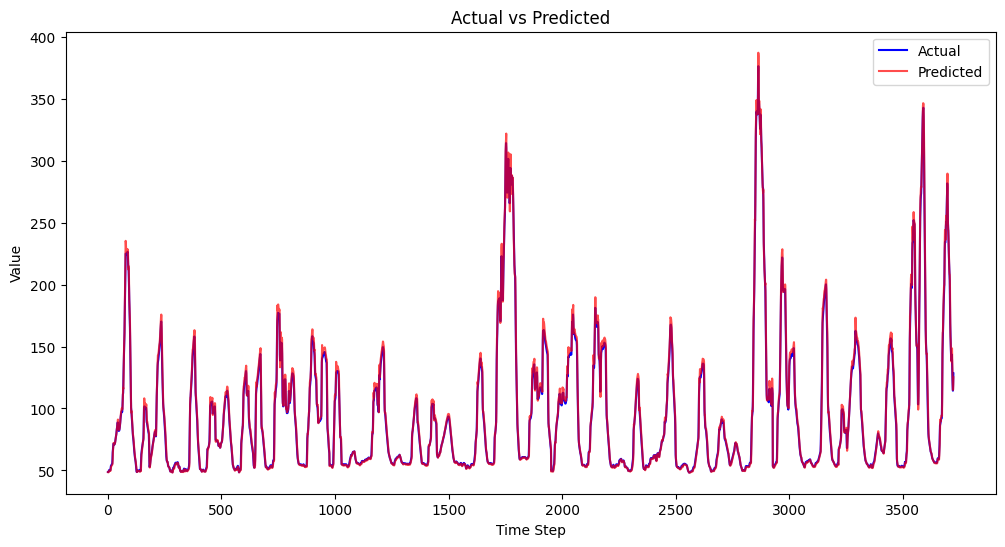

In [11]:
# Compare the test results: Actual values vs Predicted values

# Plot width
x_size=12
# Plot height
y_size=6
# Print Compare_graph
compare_graph(real_values, real_pred_values, x_size, y_size)